# Preparation

In [161]:
%matplotlib inline

import json
import random
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
from constants import ID2LABEL

In [162]:
# Preparation: Load the dataset

def load_jsonl(file_path):
    """Load a JSONL file and return a list of dictionaries."""
    with open(file_path, 'r', encoding='utf-8') as f:
        return [json.loads(line) for line in f]

# Load train, validation, and test sets
train_data = load_jsonl("data/train_en.jsonl")
val_data = load_jsonl("data/val_en.jsonl")
test_data = load_jsonl("data/test_en.jsonl")

print("Datasets loaded successfully.")

Datasets loaded successfully.


Preview the dataset

In [163]:
# Count unique labels in the dataset
all_labels = [tag for item in train_data for tag in item['ner_tags']]
unique_labels = set(all_labels)
print(f"Number of unique labels in the dataset: {len(unique_labels)}")

Number of unique labels in the dataset: 31


In [164]:
# Preview the loaded datasets
print(f"Train Data: {len(train_data)} sentences")
print(f"Validation Data: {len(val_data)} sentences")
print(f"Test Data: {len(test_data)} sentences")

# Preview a sample
print("\nExample from Train Data:")
print(train_data[0])

Train Data: 131280 sentences
Validation Data: 16410 sentences
Test Data: 16454 sentences

Example from Train Data:
{'tokens': ['The', 'type', 'locality', 'is', 'Kīlauea', '.'], 'ner_tags': [0, 0, 0, 0, 5, 0], 'lang': 'en'}


In [165]:
# Data Analysis Functions

def dataset_overview(dataset, name="Dataset"):
    print(f"# {name} - Dataset Overview\n")
    sentence_lengths = [len(item['tokens']) for item in dataset]
    print(f"- Number of sentences: {len(dataset)}")
    print(f"- Total tokens: {sum(sentence_lengths)}")
    print(f"- Average sentence length: {np.mean(sentence_lengths):.2f} tokens")
    print(f"- Max sentence length: {np.max(sentence_lengths)} tokens")
    print(f"- Min sentence length: {np.min(sentence_lengths)} tokens")
    print("\n" + "-"*50 + "\n")

def clean_dataset(dataset, name="Dataset"):
    print(f"# {name} - Cleaning Missing Data\n")
    initial_len = len(dataset)
    cleaned_dataset = [
        item for item in dataset
        if item.get('tokens') and item.get('ner_tags') and len(item['tokens']) == len(item['ner_tags'])
    ]
    removed = initial_len - len(cleaned_dataset)
    print(f"- Removed {removed} invalid samples.\n")
    return cleaned_dataset

def plot_ner_distribution(dataset, name="Dataset", o_tag=0):
    print(f"# {name} - NER Tag Distribution (Excluding 'O') (%)\n")
    
    # Flatten all tags and remove 'O'
    all_labels = [tag for item in dataset for tag in item['ner_tags'] if tag != o_tag]
    
    label_counter = Counter(all_labels)
    total = sum(label_counter.values())
    label_percentages = {tag: (count / total) * 100 for tag, count in label_counter.items()}
    
    for tag, percent in sorted(label_percentages.items()):
        print(f"Tag {tag}: {percent:.2f}%")
    
    plt.figure(figsize=(12, 6))
    plt.bar(label_percentages.keys(), label_percentages.values(), color='skyblue')
    plt.title(f"{name} - NER Tag Distribution (Excluding 'O') (%)")
    plt.xlabel("NER Tag ID")
    plt.ylabel("Percentage (%)")
    plt.xticks(list(label_percentages.keys()), rotation=90)
    plt.tight_layout()
    plt.show()

def plot_entity_type_distribution(dataset, name="Dataset"):
    print(f"# {name} - Entity Type Distribution (Based on 'B-' tags)\n")

    entity_types = []
    
    for item in dataset:
        for tag_id in item['ner_tags']:
            label = ID2LABEL[tag_id]
            if label.startswith('B-'):
                entity_type = label[2:]  # strip 'B-'
                entity_types.append(entity_type)
    
    if not entity_types:
        print("No entities found with 'B-' tags.")
        return

    # Count each entity type
    type_counter = Counter(entity_types)
    total = sum(type_counter.values())

    # Print counts
    print("Entity Counts:")
    for etype, count in sorted(type_counter.items()):
        print(f"- {etype}: {count}")

    # Compute percentages
    type_percentages = {etype: (count / total) * 100 for etype, count in type_counter.items()}

    # Plot the chart
    plt.figure(figsize=(10, 6))
    plt.bar(type_percentages.keys(), type_percentages.values(), color='mediumseagreen', edgecolor='black')
    plt.title(f"{name} - Entity Type Distribution (%)")
    plt.xlabel("Entity Type")
    plt.ylabel("Percentage (%)")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def sentence_length_analysis(dataset, name="Dataset"):
    print(f"# {name} - Sentence Length Analysis\n")
    sentence_lengths = [len(item['tokens']) for item in dataset]
    print(f"- Average: {np.mean(sentence_lengths):.2f}")
    print(f"- Max: {np.max(sentence_lengths)}")
    print(f"- Min: {np.min(sentence_lengths)}")
    
    plt.figure(figsize=(10, 6))
    plt.hist(sentence_lengths, bins=30, color='lightgreen', edgecolor='black')
    plt.title(f"{name} - Sentence Length Distribution")
    plt.xlabel("Sentence Length (tokens)")
    plt.ylabel("Number of Sentences")
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

def entity_span_analysis(dataset, name="Dataset"):
    print(f"# {name} - Entity Span Analysis\n")
    
    span_lengths = []
    
    for item in dataset:
        span = 0
        for tag in item['ner_tags']:
            if tag != 0:  # non-'O' tag
                span += 1
            else:
                if span > 0:
                    span_lengths.append(span)
                    span = 0
        # Handle last span if sentence ends with an entity
        if span > 0:
            span_lengths.append(span)
    
    if span_lengths:
        print(f"- Total entities: {len(span_lengths)}")
        print(f"- Average entity span: {np.mean(span_lengths):.2f} tokens")
        print(f"- Max span: {max(span_lengths)} tokens")
        print(f"- Min span: {min(span_lengths)} tokens\n")
        
        plt.figure(figsize=(10, 6))
        plt.hist(span_lengths, bins=range(1, max(span_lengths)+2), align='left',
                 color='lightcoral', edgecolor='black')
        plt.title(f"{name} - Entity Span Length Distribution")
        plt.xlabel("Entity Span Length (tokens)")
        plt.ylabel("Number of Entities")
        plt.xticks(range(1, max(span_lengths)+1))
        plt.grid(axis='y')
        plt.tight_layout()
        plt.show()
    else:
        print("- No entities found!\n")

def preview_random_sentences(dataset, name="Dataset", n=3):
    print(f"# {name} - Random Sentence Samples\n")
    for i in range(n):
        example = random.choice(dataset)
        print(f"Sentence {i+1}:")
        print("Tokens:", " ".join(example['tokens']))
        print("NER Tags:", example['ner_tags'])
        print("\n" + "-"*50 + "\n")


# Data Analasys

## Train Dataset

### Clean Dataset

In [166]:
train_data = clean_dataset(train_data, name="Train")

# Train - Cleaning Missing Data

- Removed 0 invalid samples.



### Overview

In [167]:
dataset_overview(train_data, name="Train")

# Train - Dataset Overview

- Number of sentences: 131280
- Total tokens: 2842119
- Average sentence length: 21.65 tokens
- Max sentence length: 237 tokens
- Min sentence length: 2 tokens

--------------------------------------------------



### NER Tag Distribution
Analyze the frequency of each NER tag in the dataset and visualize the distribution.

# Train - NER Tag Distribution (Excluding 'O') (%)

Tag 1: 17.33%
Tag 2: 18.21%
Tag 3: 7.60%
Tag 4: 9.90%
Tag 5: 16.14%
Tag 6: 6.71%
Tag 7: 3.50%
Tag 8: 1.46%
Tag 9: 0.04%
Tag 10: 0.01%
Tag 11: 0.74%
Tag 12: 0.41%
Tag 13: 2.39%
Tag 14: 1.60%
Tag 15: 0.69%
Tag 16: 1.16%
Tag 17: 2.28%
Tag 18: 0.83%
Tag 19: 0.10%
Tag 20: 0.10%
Tag 21: 1.67%
Tag 22: 2.76%
Tag 23: 0.16%
Tag 24: 0.03%
Tag 25: 2.05%
Tag 26: 0.65%
Tag 27: 0.70%
Tag 28: 0.54%
Tag 29: 0.11%
Tag 30: 0.13%


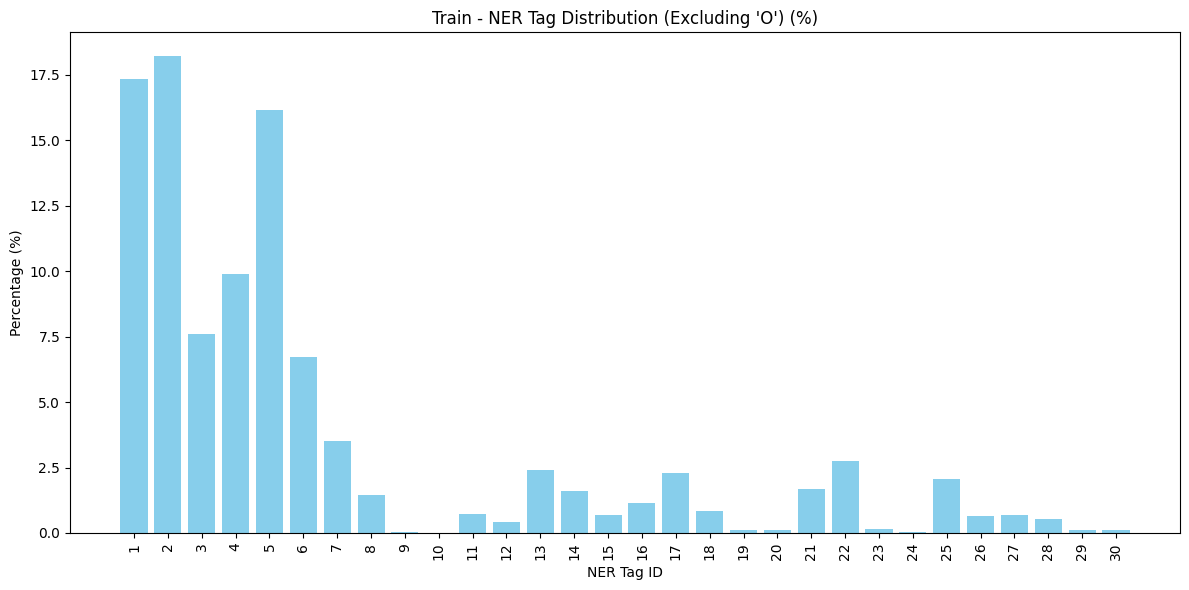

In [168]:
plot_ner_distribution(train_data, name="Train")

- Tags 1, 2, and 5 are the most frequent (~16–18%)

- Many tags have very low frequency (<2%)

- Clear class imbalance — a few tags dominate

### Sentence Length Analysis

# Train - Sentence Length Analysis

- Average: 21.65
- Max: 237
- Min: 2


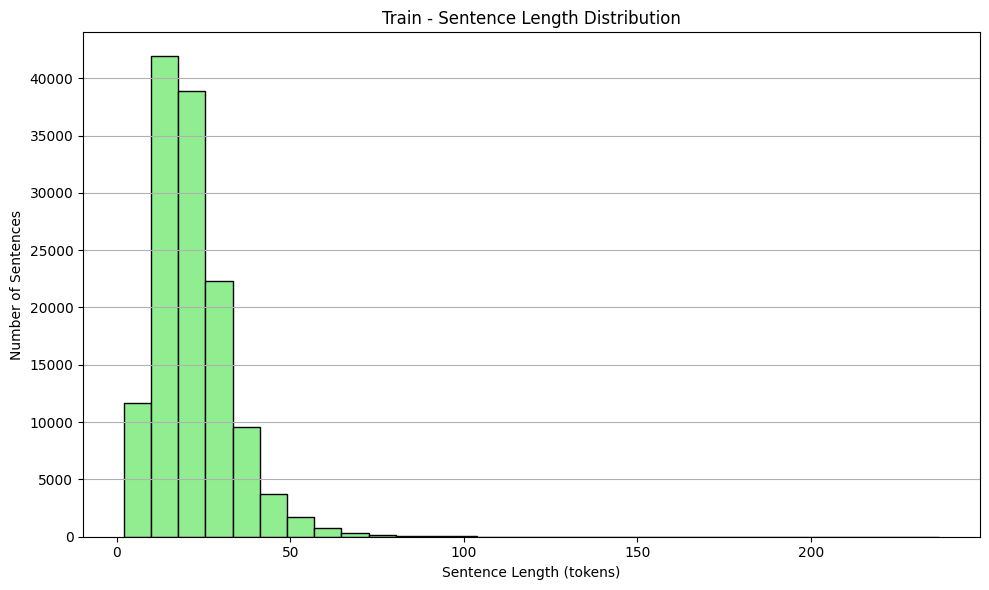

In [169]:
sentence_length_analysis(train_data, name="Train")

- Most sentences have 10–30 tokens.

- Few sentences are longer than 50 tokens.
- Very few outliers (over 100 tokens).

- Dataset is dominated by short to medium sentences.

### Entity Distribution

# Train - Entity Type Distribution (Based on 'B-' tags)

Entity Counts:
- ANIM: 12736
- BIO: 140
- CEL: 2685
- DIS: 8702
- EVE: 2525
- FOOD: 8279
- INST: 379
- LOC: 58665
- MEDIA: 6081
- MYTH: 569
- ORG: 27641
- PER: 62987
- PLANT: 7436
- TIME: 2540
- VEHI: 404


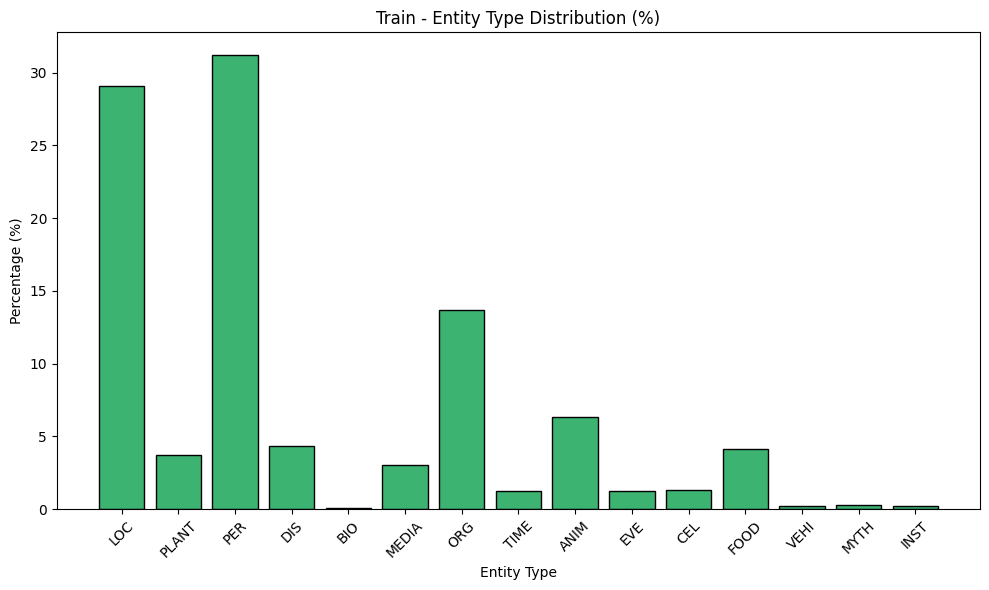

In [170]:
plot_entity_type_distribution(train_data, name="Train")

- PER and LOC are the most frequent entity types, each over 28%.

- ORG also appears significantly (~13%).

- Several types (e.g., VEHI, MYTH, INST) are extremely rare (<1%).

- The distribution is imbalanced — a few entity types dominate the dataset.

### Entity Span Analysis

# Train - Entity Span Analysis

- Total entities: 201501
- Average entity span: 1.80 tokens
- Max span: 21 tokens
- Min span: 1 tokens



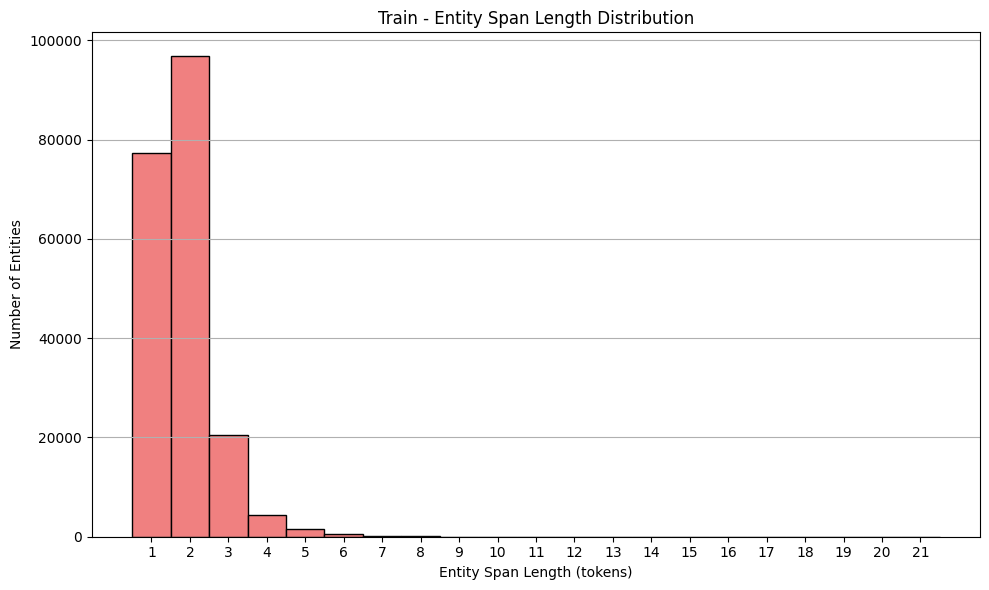

In [171]:
entity_span_analysis(train_data, name="Train")

- Most entities are 1–2 tokens long.

- Very few entities have more than 3 tokens.

- Long entities (>5 tokens) are extremely rare.

- Dataset mostly contains short named entities.

### Sample Sentences

In [172]:
preview_random_sentences(train_data, name="Train")

# Train - Random Sentence Samples

Sentence 1:
Tokens: He died in 1911 in his birthplace , Vicenza .
NER Tags: [0, 0, 0, 0, 0, 0, 0, 0, 5, 0]

--------------------------------------------------

Sentence 2:
Tokens: The party lost 5 seats and leader Mogens Lykketoft resigned immediately after the election .
NER Tags: [0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0]

--------------------------------------------------

Sentence 3:
Tokens: Biochemists Francis Crick and Leslie Orgel laid special emphasis on this uncertainty : " At the moment we have no means at all of knowing " whether we are " likely to be alone in the galaxy ( Universe ) " or whether " the galaxy may be pullulating with life of many different forms .
NER Tags: [0, 1, 2, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

--------------------------------------------------



## Validation Dataset

### Clean Dataset

In [173]:
val_data = clean_dataset(val_data, name="Validation")

# Validation - Cleaning Missing Data

- Removed 0 invalid samples.



### Overview

In [174]:
dataset_overview(val_data, name="Validation")

# Validation - Dataset Overview

- Number of sentences: 16410
- Total tokens: 379011
- Average sentence length: 23.10 tokens
- Max sentence length: 170 tokens
- Min sentence length: 2 tokens

--------------------------------------------------



### NER Tag Distribution
Analyze the frequency of each NER tag in the dataset and visualize the distribution.

# Validation - NER Tag Distribution (Excluding 'O') (%)

Tag 1: 15.98%
Tag 2: 17.01%
Tag 3: 5.83%
Tag 4: 8.33%
Tag 5: 16.71%
Tag 6: 7.70%
Tag 7: 2.41%
Tag 8: 1.23%
Tag 9: 0.03%
Tag 10: 0.01%
Tag 11: 0.20%
Tag 12: 0.04%
Tag 13: 3.61%
Tag 14: 2.66%
Tag 15: 0.64%
Tag 16: 1.15%
Tag 17: 4.51%
Tag 18: 1.76%
Tag 19: 0.07%
Tag 20: 0.05%
Tag 21: 1.96%
Tag 22: 3.00%
Tag 23: 0.12%
Tag 24: 0.02%
Tag 25: 2.51%
Tag 26: 0.88%
Tag 27: 0.69%
Tag 28: 0.54%
Tag 29: 0.17%
Tag 30: 0.19%


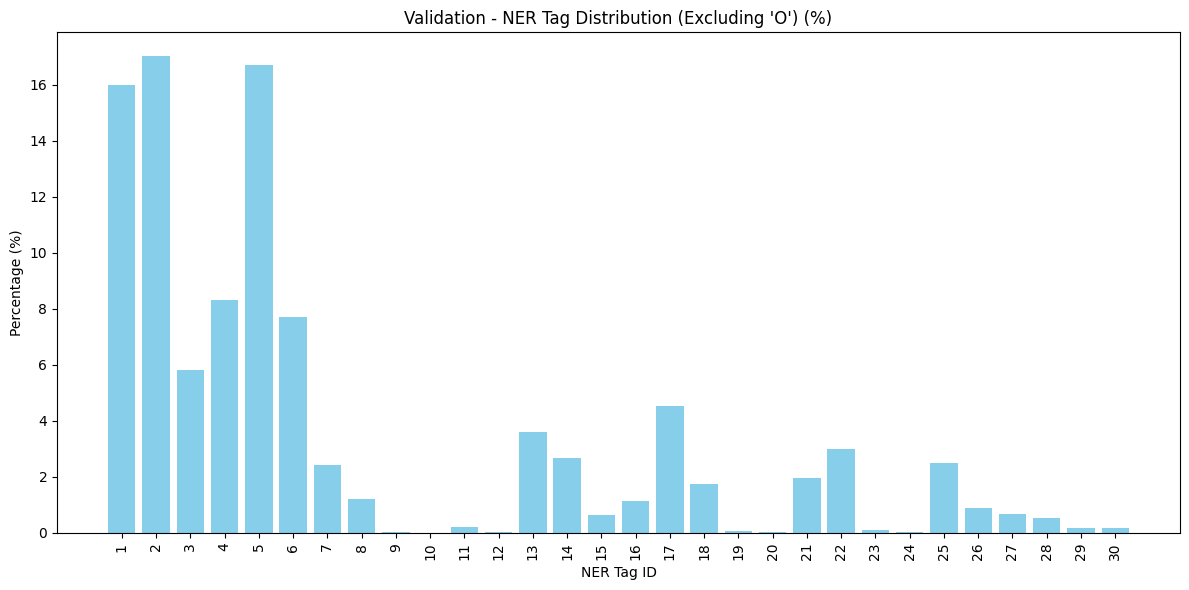

In [175]:
plot_ner_distribution(val_data, name="Validation")

- Tag IDs 1, 2, and 5 are the most frequent, each around 16–17%.

- Several tags beyond ID 10 have very low representation (<2%).

- The distribution is imbalanced, similar to the training set.

### Sentence Length Analysis

# Validation - Sentence Length Analysis

- Average: 23.10
- Max: 170
- Min: 2


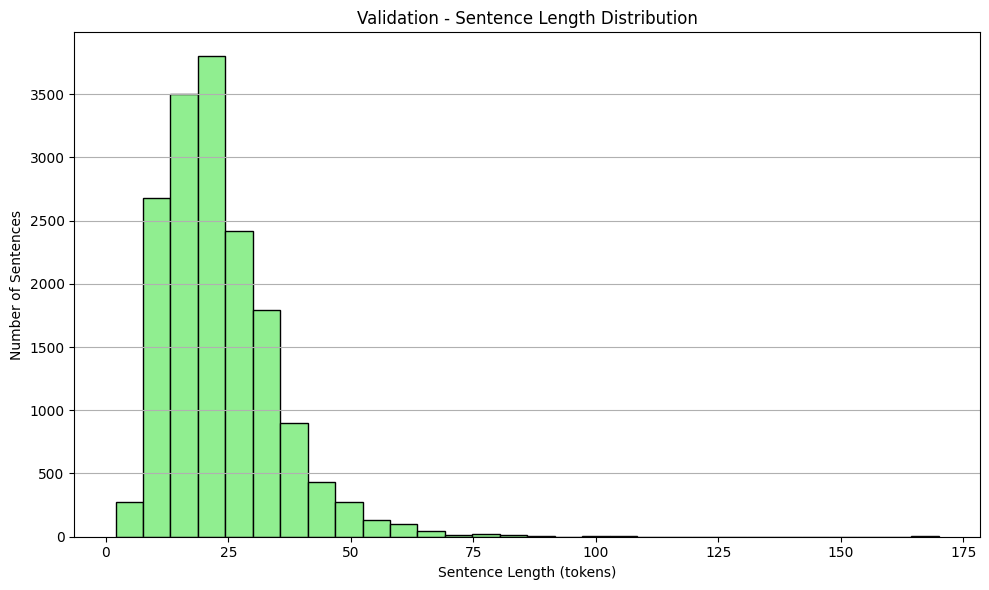

In [176]:
sentence_length_analysis(val_data, name="Validation")

- Most sentences are around 15–30 tokens.

- Only a few sentences are longer than 50 tokens.

- Long sentences (>100 tokens) are very rare.

- Overall, validation sentences are short to medium length, matching the train set pattern.



### Entity Distribution

# Valdiation - Entity Type Distribution (Based on 'B-' tags)

Entity Counts:
- ANIM: 1134
- BIO: 14
- CEL: 94
- DIS: 1695
- EVE: 299
- FOOD: 2120
- INST: 34
- LOC: 7850
- MEDIA: 919
- MYTH: 56
- ORG: 2737
- PER: 7507
- PLANT: 1180
- TIME: 322
- VEHI: 80


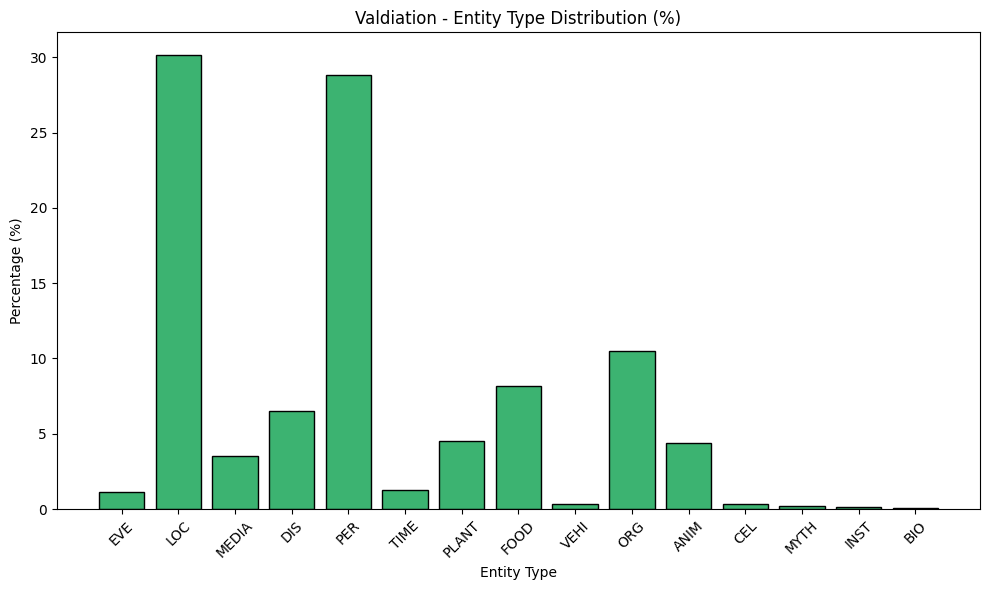

In [177]:
plot_entity_type_distribution(val_data, name="Valdiation")

- LOC and PER are the most dominant types, each close to 30%.

- ORG and FOOD also have notable presence (~10% and 8%).

- Many types like BIO, INST, MYTH, and CEL are rare (<1%).

### Entity Span Analysis

# Validation - Entity Span Analysis

- Total entities: 26001
- Average entity span: 1.81 tokens
- Max span: 12 tokens
- Min span: 1 tokens



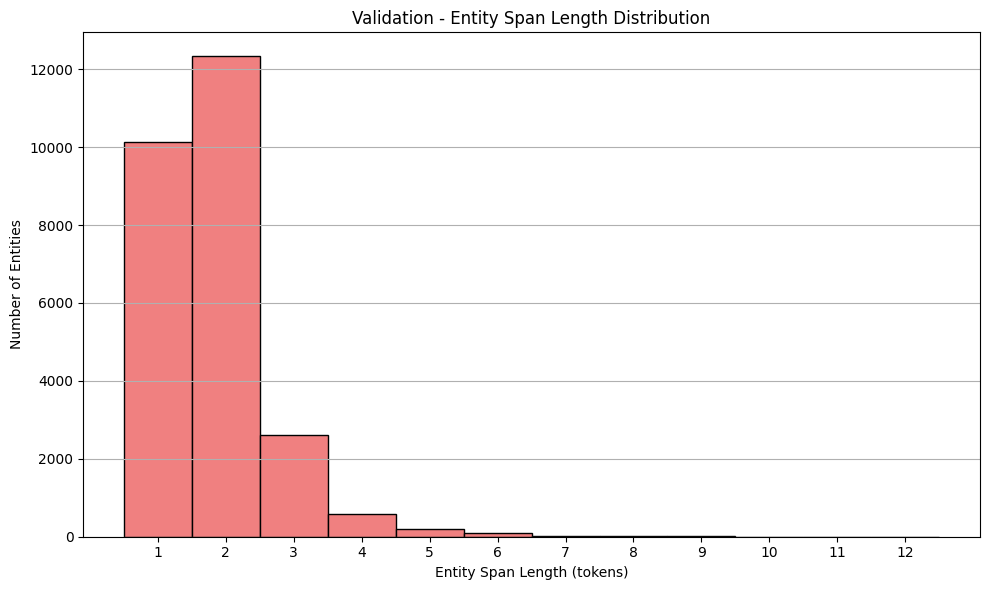

In [178]:
entity_span_analysis(val_data, name="Validation")

- Most entities are 1–2 tokens long.

- Very few entities have more than 3 tokens.

- Long entities (>5 tokens) are almost nonexistent.

### Sample Sentences

In [179]:
preview_random_sentences(val_data, name="Validation")

# Validation - Random Sentence Samples

Sentence 1:
Tokens: The " pound " was the currency of Connecticut until 1793 .
NER Tags: [0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0]

--------------------------------------------------

Sentence 2:
Tokens: While the immediate response of the Vatican has not yet come to light , a limited group of scholars had been granted access by 1991 .
NER Tags: [0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

--------------------------------------------------

Sentence 3:
Tokens: She is also a trained opera singer who studied voice and opera at the Boston University Tanglewood Institute .
NER Tags: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 4, 4, 4, 0]

--------------------------------------------------



## Test Dataset

### Clean Dataset

In [180]:
test_data = clean_dataset(test_data, name="Test")

# Test - Cleaning Missing Data

- Removed 0 invalid samples.



### Overview

In [181]:
dataset_overview(test_data, name="Test")

# Test - Dataset Overview

- Number of sentences: 16454
- Total tokens: 347025
- Average sentence length: 21.09 tokens
- Max sentence length: 148 tokens
- Min sentence length: 4 tokens

--------------------------------------------------



### NER Tag Distribution
Analyze the frequency of each NER tag in the dataset and visualize the distribution.

# Test - NER Tag Distribution (Excluding 'O') (%)

Tag 1: 11.55%
Tag 2: 12.57%
Tag 3: 7.26%
Tag 4: 10.05%
Tag 5: 26.38%
Tag 6: 13.08%
Tag 7: 3.52%
Tag 8: 2.03%
Tag 9: 0.02%
Tag 11: 0.09%
Tag 12: 0.04%
Tag 13: 1.67%
Tag 14: 1.10%
Tag 15: 0.77%
Tag 16: 1.33%
Tag 17: 1.24%
Tag 18: 0.40%
Tag 19: 0.03%
Tag 20: 0.03%
Tag 21: 1.00%
Tag 22: 1.69%
Tag 23: 0.07%
Tag 24: 0.02%
Tag 25: 1.96%
Tag 26: 0.87%
Tag 27: 0.63%
Tag 28: 0.46%
Tag 29: 0.07%
Tag 30: 0.07%


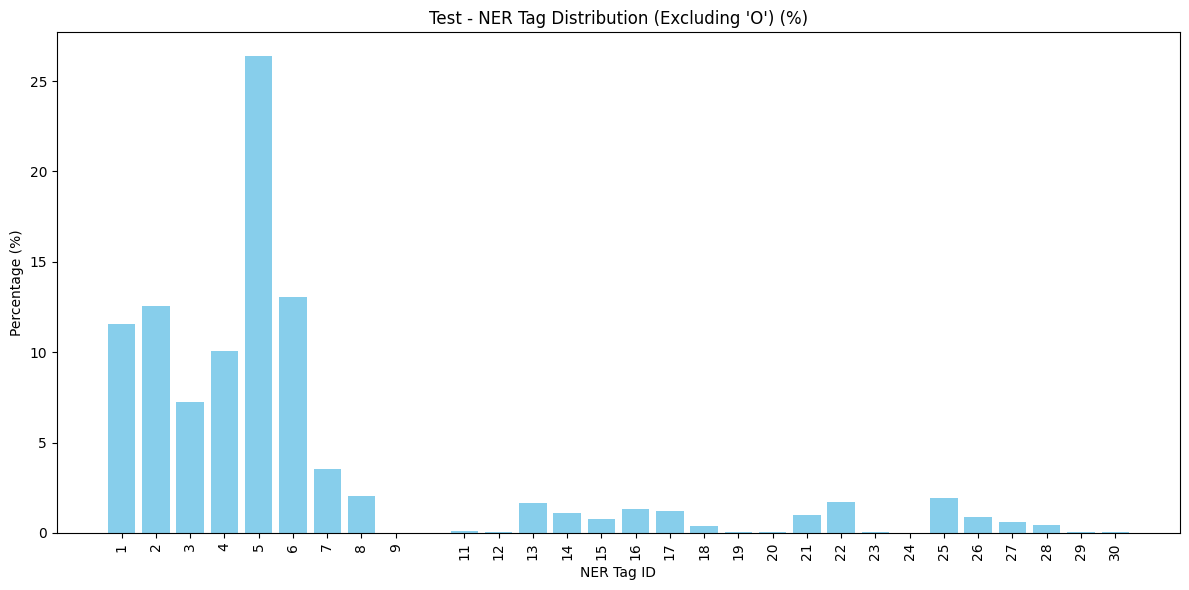

In [182]:
plot_ner_distribution(test_data, name="Test")

- Tag 5 dominates the distribution with over 26%.

- Tags 1, 2, 4, and 6 are also frequent (10–13%).

- Most other tags have very low frequency (<2%).

### Sentence Length Analysis

# Test - Sentence Length Analysis

- Average: 21.09
- Max: 148
- Min: 4


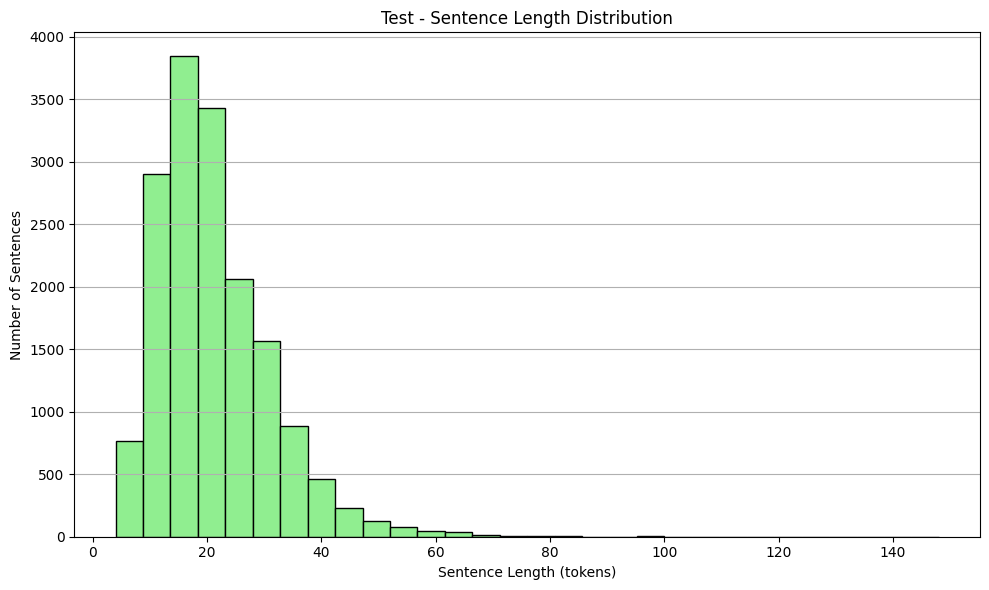

In [183]:
sentence_length_analysis(test_data, name="Test")

- Most sentences are between 15–30 tokens.

- Very few sentences are longer than 50 tokens.

- Long sentences (>100 tokens) are extremely rare.

### Entity Distribution

# Test - Entity Type Distribution (Based on 'B-' tags)

Entity Counts:
- ANIM: 1604
- BIO: 8
- CEL: 41
- DIS: 759
- EVE: 352
- FOOD: 566
- INST: 12
- LOC: 12024
- MEDIA: 458
- MYTH: 32
- ORG: 3309
- PER: 5265
- PLANT: 894
- TIME: 289
- VEHI: 32


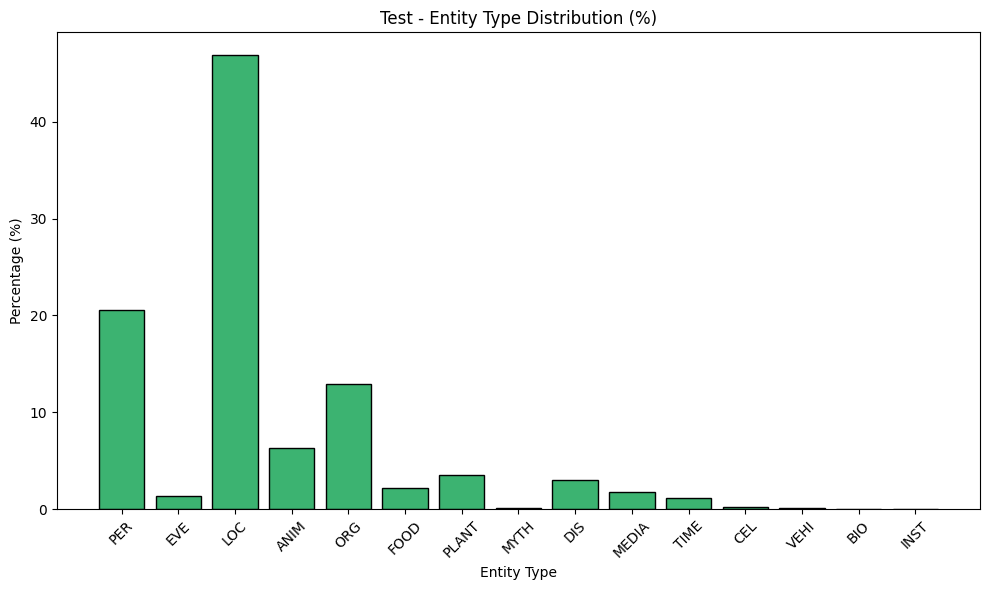

In [184]:
plot_entity_type_distribution(test_data, name="Test")

- LOC is the most dominant type, making up nearly 47%.

- PER and ORG follow, at ~21% and ~13%.

- Many types like BIO, INST, and VEHI are nearly absent (<1%).

- The distribution is highly imbalanced, favoring a few major types.

### Entity Span Analysis

# Test - Entity Span Analysis

- Total entities: 25610
- Average entity span: 1.78 tokens
- Max span: 12 tokens
- Min span: 1 tokens



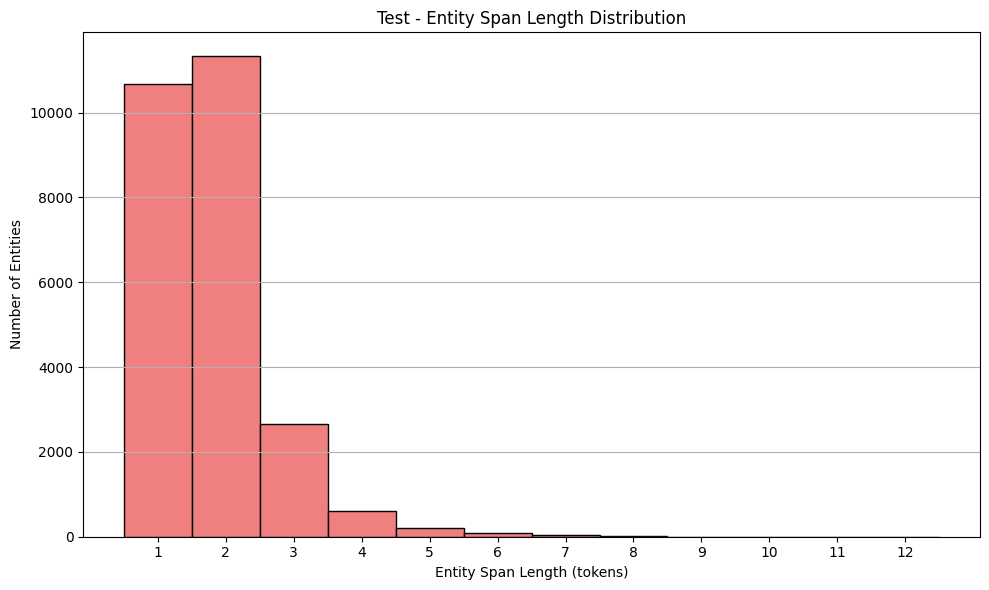

In [185]:
entity_span_analysis(test_data, name="Test")

- Most entities are 1–2 tokens long.

- Entities longer than 3 tokens are rare.

- Very few long entities (>5 tokens).



### Sample Sentences

In [186]:
preview_random_sentences(test_data, name="Test")

# Test - Random Sentence Samples

Sentence 1:
Tokens: The company scarcely had a chance for success before the Great Depression hit .
NER Tags: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 27, 28, 0, 0]

--------------------------------------------------

Sentence 2:
Tokens: On January 18 , 2020 , he broke the club record with 472 games played for the club , surpassing Petar Božić at the all-time list .
NER Tags: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0]

--------------------------------------------------

Sentence 3:
Tokens: The college opposed firing any employees in response and neglected to issue formal responses to many of the other demands , though it has sought to cut wages and health care funds for administrators , office workers and library support staff during contract negotiations with the Office and Professional Employees International Union .
NER Tags: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

# EDA Conclusion

- The data is highly imbalanced across all splits, with LOC, PER, and ORG dominating while many other types are rare, potentially biasing the model toward frequent entities.

- Sentence lengths are mostly short to medium (15–30 tokens) in all sets.

- Entity spans are mostly 1–2 tokens, with very few longer entities.

- Patterns are consistent across Train, Validation, and Test sets.